In [1]:
## Data handlers
from dask_jobqueue import *
from dask.distributed import *
import xarray as xr
import numpy as np
import pandas as pd
import datetime
import netCDF4 
from dask import delayed
from dask import compute
from dask.diagnostics import*
from tqdm import tqdm
import dask
## Plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.mlab as mlab
import matplotlib.colors as mcl
from mpl_toolkits import axes_grid1
import seaborn as sns
import matplotlib.dates as mdates
import geopandas
import rioxarray
from shapely.geometry import mapping
## Global config
import os, sys, glob
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: 
    sys.path.append(module_path)
import config 
import gc
import warnings
warnings.filterwarnings('ignore')

/home/civil/phd/cez218606/anaconda3/envs/geo_env/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/home/civil/phd/cez218606/anaconda3/envs/geo_env/lib/python3.10/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(


In [2]:
mask =  geopandas.read_file("/home/civil/phd/cez218606/Auto_calibration/Final/Ganga_PDDS/output/pyLISF/shapefiles/Ganga.shp")


<AxesSubplot:>

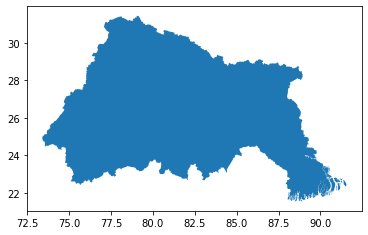

In [3]:
mask.plot()

In [4]:
    
PARM = pd.read_csv('/home/civil/phd/cez218606/Auto_calibration/Final/Ganga_PDDS/NoahMP_InputFiles/best_parm/PARAMS')
ds = xr.open_dataset("/home/civil/phd/cez218606/Auto_calibration/Final/Ganga_PDDS/lis_input_files/lis_input_ildas_noahmp401_010.nc")
ds1 = xr.open_dataset("/home/civil/phd/cez218606/Auto_calibration/Final/Ganga_PDDS/lis_input_files/lis_input_ildas_noahmp401_010.nc")
mask =  geopandas.read_file("/home/civil/phd/cez218606/Auto_calibration/Final/Ganga_PDDS/output/pyLISF/shapefiles/Ganga.shp")

a = config.reformat_LIS_output(ds)
aa = a.LANDMASK
bb = a.DOMAINMASK
cc = a.HYMAP_runoff_time_delay
dd = a.HYMAP_river_roughness

aa.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
aa.rio.write_crs("epsg:4326", inplace=True)
lsm_clip = aa.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)
bb.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
bb.rio.write_crs("epsg:4326", inplace=True)
lsm_clip1 = bb.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)
cc.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
cc.rio.write_crs("epsg:4326", inplace=True)
lsm_clip2 = cc.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)
dd.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
dd.rio.write_crs("epsg:4326", inplace=True)
lsm_clip3 = dd.rio.clip(mask.geometry.apply(mapping), mask.crs, drop=True)

a = a.assign(LANDMASK = lsm_clip)
a = a.assign(DOMAINMASK = lsm_clip1)
a = a.assign(HYMAP_runoff_time_delay = cc)
a = a.assign(HYMAP_river_roughness = dd)

aaa = a.LANDMASK
aaa1 = a.DOMAINMASK
aaa2 = a.HYMAP_runoff_time_delay*PARM.Parameters[0]
aaa3 = a.HYMAP_river_roughness*PARM.Parameters[1]

aaa = aaa.fillna(0)
aaa1 = aaa1.fillna(0)

## Create east_west and north_south grid for the LIS domain 
min_lon = 64.55
min_lat = 5.05
max_lon = 99.95
max_lat = 37.95
lat = np.arange(5.0499,37.95,0.1).reshape(330,1).repeat(355,axis=1)
lon = np.arange(64.5499,99.95,0.1).reshape(1,355).repeat(330,axis=0)

landmask = xr.Dataset({
            'LANDMASK': xr.DataArray(
                        data   = aaa,   # enter data here
                        dims   = ["north_south","east_west"],
                        coords = {"lon":(["north_south","east_west"],lon),"lat":(["north_south","east_west"],lat)},

                )},   
        )




domainmask = xr.Dataset({
            'DOMAINMASK': xr.DataArray(
                        data   = aaa1,   # enter data here
                        dims   = ["north_south","east_west"],
                        coords = {"lon":(["north_south","east_west"],lon),"lat":(["north_south","east_west"],lat)},

                )},   
        )






bedrock = xr.Dataset({
            'HYMAP_runoff_time_delay': xr.DataArray(
                        data   = aaa2,   # enter data here
                        dims   = ["north_south","east_west"],
                        coords = {"lon":(["north_south","east_west"],lon),"lat":(["north_south","east_west"],lat)},

                )},   
        )
decay = xr.Dataset({
            'HYMAP_river_roughness': xr.DataArray(
                        data   = aaa3,   # enter data here
                        dims   = ["north_south","east_west"],
                        coords = {"lon":(["north_south","east_west"],lon),"lat":(["north_south","east_west"],lat)},

                )},   
        )


landmask1 = landmask.drop('lon', dim=None)
landmask2 = landmask1.drop('lat', dim=None)
ds1['LANDMASK'] = landmask2.LANDMASK



domainmask1 = domainmask.drop('lon', dim=None)
domainmask2 = domainmask1.drop('lat', dim=None)
ds1['DOMAINMASK'] = domainmask2.DOMAINMASK



bedrock1 = bedrock.drop('lon', dim=None)
bedrock2 = bedrock1.drop('lat', dim=None)
ds1['HYMAP_runoff_time_delay'] = bedrock2.HYMAP_runoff_time_delay

decay1 = decay.drop('lon', dim=None)
decay2 = decay1.drop('lat', dim=None)
ds1['HYMAP_river_roughness'] = decay2.HYMAP_river_roughness


ds1.to_netcdf('/home/civil/phd/cez218606/Auto_calibration/Final/Ganga_PDDS/lis_input_files/lis_input_ildas_noahmp401_010_Ganga_final.nc')
